# Semester assignment
* In this notebook I will create a convolutionary neural network
* I plan it to be a 2x upscaler
* I will use PyTorch library for model, training and interference
* I will use OpenCV for image processing
* I will use DIV2K dataset aviable at https://www.kaggle.com/datasets/joe1995/div2k-dataset/data?select=DIV2K_train_HR
* I will use a Unet architecture

### 1. Importing needed libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import kagglehub
import pathlib
import os
import sys
import random
import torchmetrics

from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


/home/radekbys/Code/Unet_Upscalers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Downloading dataset before moving it to project location

In [2]:
# # Download latest version of dataset
# path = kagglehub.dataset_download("joe1995/div2k-dataset")
# print("Path to dataset files:", path)

### 3. Resizing images

FOr supervised training two sets of images are needed, one in the base resolution tat will be upscaled and one in the target resolution

In [3]:
# base_path = pathlib.Path("./dataset/DIV2K_train_HR")

# for i in range(1, 801):
#     image = cv2.imread(base_path / "DIV2K_train_HR" / f"{i:04d}.png")  # reading image
#     large_image = cv2.resize(image, (1280, 720))
#     cv2.imwrite(
#         base_path / "Large" / f"{i:04d}.png", large_image
#     )  # saving large image for y tensor in training

#     small_image = cv2.resize(large_image, (640, 360))
#     cv2.imwrite(base_path / "Downscaled" / f"{i:04d}.png", small_image)

In [4]:
# base_path = pathlib.Path("./dataset/DIV2K_valid_HR")

# for i in range(801, 901):
#     image = cv2.imread(base_path / "DIV2K_valid_HR" / f"{i:04d}.png")  # reading image
#     large_image = cv2.resize(image, (1280, 720))
#     cv2.imwrite(
#         base_path / "Large" / f"{i:04d}.png", large_image
#     )  # saving large image for y tensor in training

#     small_image = cv2.resize(large_image, (640, 360))
#     cv2.imwrite(base_path / "Downscaled" / f"{i:04d}.png", small_image)

# 4. Creating training and testing datasets

* to create this datasets I prepared a custom dataset class based on torch.utils.data.Dataset
* it loads all the images ussed below to ram memory to significantly speed up the learning process

In [5]:
class DIV2KDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Define the paths for downscaled and large images
        self.downscaled_dir = os.path.join(root_dir, 'Downscaled')
        self.large_dir = os.path.join(root_dir, 'Large')
        
        # List all image files in the downscaled directory
        self.image_filenames = sorted(os.listdir(self.downscaled_dir))
        
        # Preload all data into RAM
        self.data = []
        for filename in self.image_filenames:
            # Load downscaled image
            downscaled_path = os.path.join(self.downscaled_dir, filename)
            large_path = os.path.join(self.large_dir, filename)
            
            X = cv2.imread(downscaled_path)
            X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
            X = X.astype(np.float32) / 255.0
            
            y = cv2.imread(large_path)
            y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
            y = y.astype(np.float32) / 255.0
            
            if self.transform:
                X = self.transform(X)
                y = self.transform(y)
            
            self.data.append((X, y))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


### Creating datasets

In [6]:
train_dataset = DIV2KDataset(root_dir='dataset/DIV2K_train_HR', transform=transforms.ToTensor())
testing_dataset = DIV2KDataset(root_dir='dataset/DIV2K_valid_HR', transform=transforms.ToTensor())

len(train_dataset), len(testing_dataset)

(800, 100)

### visualization
Here I am checking if the datasets have been created correctly

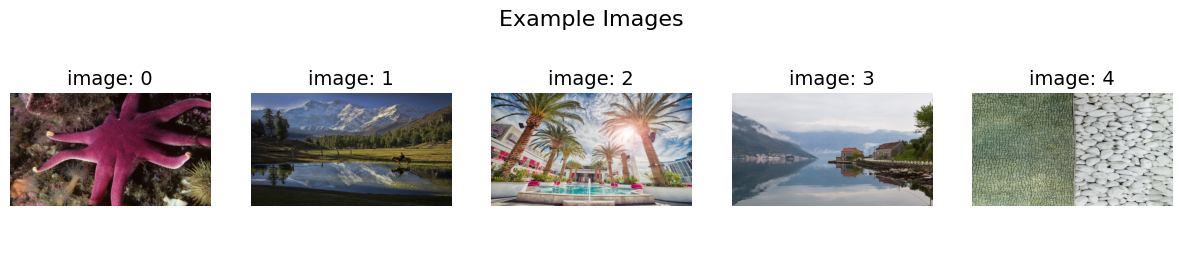

In [7]:
plt.figure(figsize=(15,3))
plt.title("Example Images", fontsize=16)
plt.axis("off")
for i, (image, target) in enumerate(train_dataset):
    if i >= 5:
        break
    plt.subplot(1, 5, i+1)
    plt.title(f"image: {i}", fontsize=14)
    plt.imshow(image.squeeze().permute(1,2,0).cpu())
    plt.axis("off")

plt.show()

### Creating dataloaders

* dataloaders are needed to access images in batches to perform training.
* training on whole dataset at once is not viable, becauase it would use way too mych vram
* I use batch size of 1, beacouse of vram limitations

In [8]:
train_dataloader = DataLoader(train_dataset, 1, shuffle=True)
test_dataloader = DataLoader(testing_dataset, 1, shuffle=False)
len(train_dataloader), len(test_dataloader)

(800, 100)

# 5. Creating a model

* The below model is my implementation of U-net architecture
* In first step I increase the image size to make it viable for downsampling during the descent into the U-net
* Then I downsample the data the data two times, and increase the number of channels in the convolution layers
* Downsampling is used to find patterns in the data
* Next I upsample the data once while reducing the number of channels
* The last part is a series of convolution layers that connect all the information into a single 3 channel image

### Layers used:
* I use Conv2d layers for convolution, I theke the parameters to more or less fit the size of image Iam convoluting at each layer
* I use LeakyReLU layers to provide nonlinearity, to prevent occurence of dead neurons, and to prevent overfitting so I don't need to use dropout layers
* I use UpsamplingNearest2d to increase the image dimensions when needed
* I also use AvgPool2d to reduce image sizes when needed

In [9]:
class UnetUpscaler(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = torch.nn.Sequential(
            # initial upsampling
            torch.nn.UpsamplingNearest2d(scale_factor=2),
            
            torch.nn.Conv2d(3, 16, 5, 1, 4, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 64, 5, 1, 4, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 256, 5, 1, 4, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256, 64, 5, 1, 4, 2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 64, 3, 1, 1, 1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 64, 3, 1, 1, 1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 64, 3, 1, 1, 1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 16, 3, 1, 1, 1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 3, 3, 1, 1, 1),
        )

    def forward(self, x):
        return self.layers(x)



model_01 = UnetUpscaler().to("cuda")

In [10]:
y = model_01(train_dataset[0][0].unsqueeze(0).to("cuda"))
print(y.shape)

torch.Size([1, 3, 720, 1280])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047766145..0.048644915].


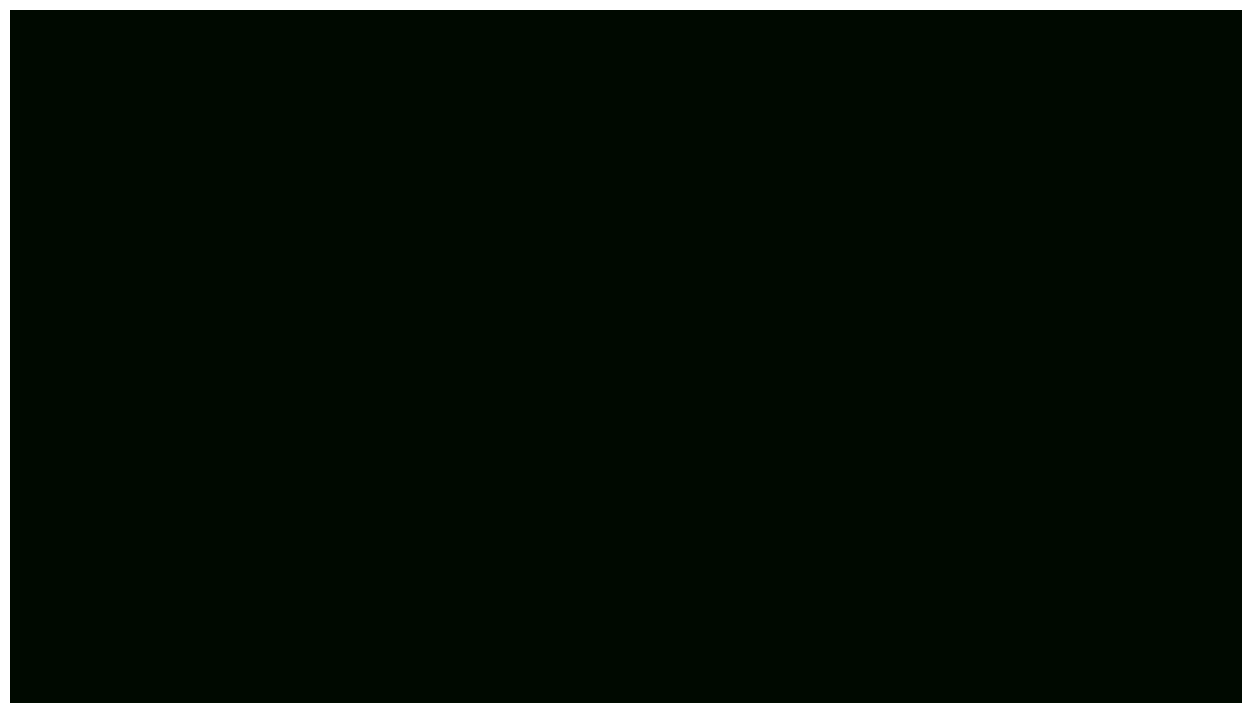

In [11]:
# example output image without training

plt.figure(figsize=(16 ,9))
plt.axis("off")
plt.imshow(y.squeeze().permute(1,2,0).cpu().detach())
plt.show()


# 6. Creating Optimizer and loss function, and loading model from a checkpoint

* as optimizer I used the Adam algorithm. It is a standard popular optimizer, and in the past I achived better results with it than with basic SGD
* as cost function I have experimented with L1Loss and smoothL1Loss. In theory L1Loss should give sharper images, though I haven't foung much diffrence in my results
* I created checkpoints in the training sessions, so I dont have to perform all the training at once

In [17]:

optimizer = torch.optim.Adam(params = model_01.parameters(), lr=0.00001)
# optimizer = torch.optim.Adam(params = model_01.parameters(), lr=0.000001)
cost_fn = torch.nn.SmoothL1Loss()

# 7. Training

* Here I perform a standard training loop
* I use my RTX 4070 for training, which is a cuda device
* I perfor evaluation once every 80 batches
* I collect each loss value of every batch and calculate the average in evaluation
* To compare it with a testing sample i choose a random image from the testing dataset
* I also use mean square error for evaluation, it can be used for evaluating regression models like this one
* After the training is finishe I save the final model weights
* 100cepochs of trainig takes around 6 hours
* this particular model I stopped training after 70 peochs, because I saw overfitting, training losses were girng down, while test losses started climbing up

In [18]:
epochs = 500
metric = torchmetrics.MeanSquaredError().to("cuda")

for epoch in range(epochs):
    losses = []
    for i, (X, y) in enumerate(train_dataloader):
        model_01.train()
        X = X.to("cuda")
        y = y.to("cuda")
        output = model_01(X)
        loss = cost_fn(input=output, target=y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 800 == 0:
            model_01.eval()
            with torch.inference_mode():

                test_losses = []
                mserrors = []
                for j in range(100):
                    # idx = random.random()
                    # idx = int(idx * 100)
                    idx = j
                    X = testing_dataset[idx][0].unsqueeze(0).to("cuda")
                    y = testing_dataset[idx][1].unsqueeze(0).to("cuda")
                    test_output = model_01(X)
                    test_loss = cost_fn(input=test_output, target=y)
                    test_losses.append(test_loss.item())
                    mse = metric(test_output, y)
                    mserrors.append(mse)

                train_loss = sum(losses) / len(losses)
                test_loss = sum(test_losses) / len(test_losses)
                mse = sum(mserrors) / len(mserrors)

                print(
                    f"epoch: {epoch+1} || train_loss: {train_loss} || test_loss: {test_loss} || mean square error: {mse}"
                )
                losses.clear()
    if (epoch + 1) % 10 == 0:
        torch.save(model_01.state_dict(), f"upscaler_ver_09_e{epoch+1}.pt")

epoch: 191 || train_loss: 0.0007882632818336788 || test_loss: 0.0007813844661723124 || mean square error: 0.0015627690590918064
epoch: 192 || train_loss: 0.0007881199199755429 || test_loss: 0.0007811592083089635 || mean square error: 0.0015623184153810143
epoch: 193 || train_loss: 0.0007880182762028199 || test_loss: 0.0007809945671397144 || mean square error: 0.0015619893092662096
epoch: 194 || train_loss: 0.0007877833244128851 || test_loss: 0.0007810973138839472 || mean square error: 0.0015621946658939123
epoch: 195 || train_loss: 0.0007876497277629823 || test_loss: 0.0007806152739794924 || mean square error: 0.0015612305141985416
epoch: 196 || train_loss: 0.0007875460647801447 || test_loss: 0.0007812283219755045 || mean square error: 0.0015624561347067356
epoch: 197 || train_loss: 0.0007873836083513197 || test_loss: 0.0007803595226505422 || mean square error: 0.001560718985274434
epoch: 198 || train_loss: 0.0007872374830026275 || test_loss: 0.0007800398074323311 || mean square error:

KeyboardInterrupt: 